In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [7]:
dim1 = 10
dim2 = 10
grid = np.zeros((dim1,dim2))
grid[dim1-1,0] = 1 #starting location

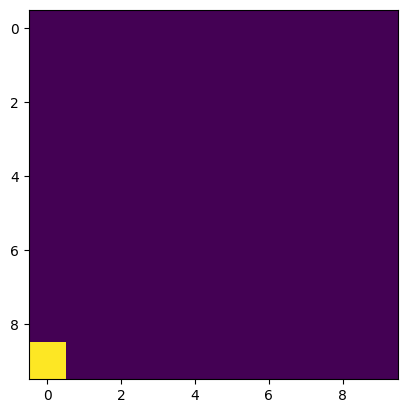

In [8]:
plt.imshow(grid)